# Extragalactic Galaxy Calculation

In principle, calculating the emission of a extragalactic galaxy is simple, we only need to adjust the sightlines to let them pointing to the same direction -- our Earth. `synax.coords.get_extragalactic_positions` kindly gives the integration positions for such tasks, you only need to give it the figure size of your final map, and $\theta$ and $\phi$ angle of the sightline direction.

In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

## Get positions!

The key difference here. We assume the final output map is a figure with size `(128,128)`. Note the $\theta$ and $\phi$ denotes the angle from galaxy to earth, not from earth to galaxy. If you find it inconvinent, please contact me to change its definition.
It will give us the normal `poss,dls,nhats`, as well as a `mask` tell us some pixels in the final map do not have any emission. We will not calculate these pixels. `resolution` is the physical size of your map, in units of kpc.

In [4]:
poss,dls,nhats,mask,resolution = synax.coords.get_extragalactic_positions(128,jnp.pi/3,jnp.pi/4)

2024-10-02 15:51:59.725005: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


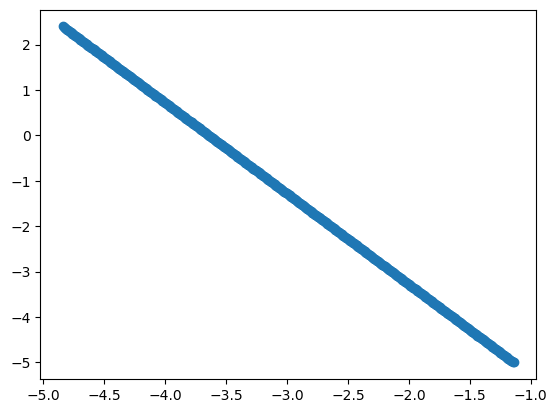

In [5]:
# projection of 1000-th line in the XZ plane
plt.scatter(poss[0,1000,:],poss[2,1000,:])

## Generates the fields
Totally the same.

In [6]:
C_generator = synax.cfield.C_WMAP(poss)

C_field = C_generator.C_field()
C_field.shape

(8216, 512)

In [7]:
nx,ny,nz = 256,256,64 # number of voxels along xyz axis

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5# get x coordinates

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5# get x coordinates

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5# get x coordinates

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

tereg = np.load('te.npy')

In [8]:
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))

In [9]:
TE_field = TE_generator.TE_field(tereg)

In [10]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

B_generator = synax.bfield.B_lsa(poss)
B_field = B_generator.B_field(lsa_params)
B_field.shape

(8216, 512, 3)

## Simulate

totally the same

In [11]:
simer = synax.synax.Synax()
freq = 2.4 # Ghz
spectral_index = 3.

In [13]:
sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)

## Visualize

Note in this case, we need to create a 0 map and paste those calculated sightlines to this map, since we're not calculating all pixs in the map.

In [14]:
Qmap,Umap = sync['Q'],sync['U']

Q_total = jnp.zeros(mask.shape[0])

U_total = jnp.zeros(mask.shape[0])

In [15]:
#Q_full = jnp.zeros_like(Q_total)
Q_total = Q_total.at[mask].set(Qmap)
U_total = U_total.at[mask].set(Umap)

Text(0.5, 1.0, 'Synax U')

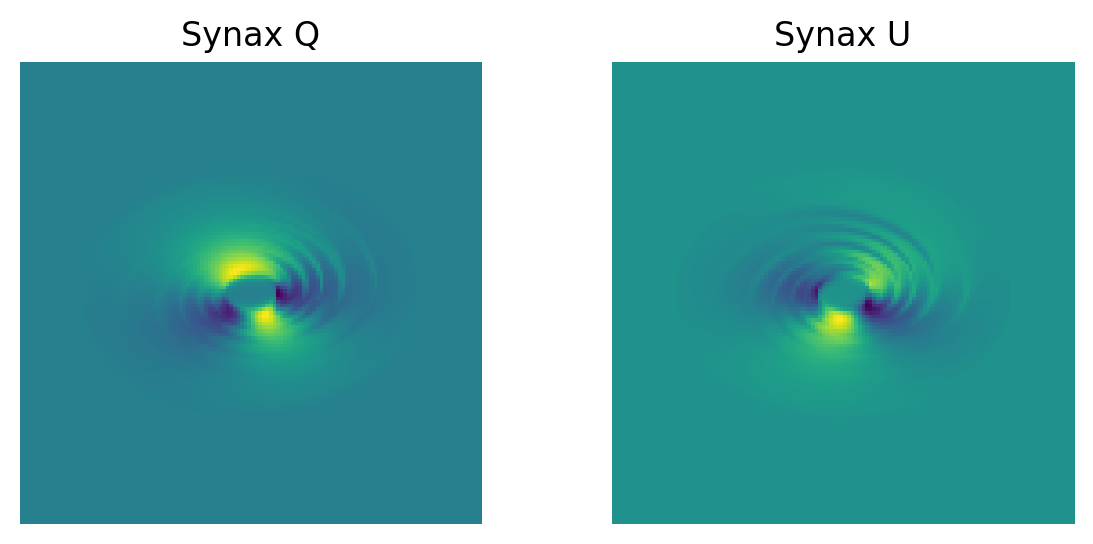

In [16]:
plt.figure(figsize = (7,3),dpi=200)

plt.subplot(121)
plt.imshow(Q_total.reshape((128,128)))
#plt.colorbar()
plt.axis('off')
plt.title('Synax Q')

plt.subplot(122)
plt.imshow(U_total.reshape((128,128)))
#plt.colorbar()
plt.axis('off')
plt.title('Synax U')

In [17]:
resolution # physical resolution of the map

Array(0.42688294, dtype=float64)